In [1]:
# Standard library imports
import time

# Third party imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from osgeo import gdal
from scipy import interpolate
from scipy.ndimage import generic_filter
import pandas as pd
import geopandas as gpd
import pyproj
import rasterio
from rasterio.features import rasterize
import shapefile as shp
import vtk
import os

# Flopy imports
import flopy
from flopy.mf6.utils.reference import SpatialReference
from flopy.utils import Raster
from flopy.utils.gridgen import StructuredGrid as StructuredGridGen
from flopy.utils.util_array import Util2d
from flopy.export import vtk as vtk_export
from flopy.export.shapefile_utils import *
import flopy.utils.binaryfile as bf
from flopy.discretization import StructuredGrid
from flopy.modflow import ModflowStr
from flopy.modflow import ModflowRch
from flopy.utils import CellBudgetFile
from flopy.modflow import ModflowNwt


# Code purpose: import modules for a Python script
print("Modules imported successfully.")


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Modules imported successfully.


In [2]:

# Load the model
sim = flopy.modflow.Modflow.load('Gondebeek.nam')

# Change the version to 'mfnwt'
sim.version = 'mfnwt'

# Check if the PCG package exists before trying to remove it
if 'PCG' in sim.get_package_list():
    sim.remove_package('PCG')

# Check if the NWT package exists before trying to remove it
if 'NWT' in sim.get_package_list():
    sim.remove_package('NWT')

# Check if the LPF package exists before trying to remove it
if 'LPF' in sim.get_package_list():
    lpf = sim.get_package('LPF')
else:
    # Try to load the LPF package from a file
    lpf_file = 'Gondebeek.lpf'
    if os.path.exists(lpf_file):
        lpf = flopy.modflow.ModflowLpf.load(lpf_file, sim)
    else:
        print("LPF package does not exist in the model or in the file. Cannot create UPW package.")
        lpf = None

if lpf is not None and hasattr(lpf, 'hk'):
    sim.remove_package('LPF')
    # Create a new UPW package with the same parameters as the LPF package
    upw = flopy.modflow.ModflowUpw(sim, hk=lpf.hk.array, 
                                   vka=lpf.vka.array, 
                                   sy=lpf.sy.array, 
                                   ss=lpf.ss.array, 
                                   laytyp=lpf.laytyp.array)
    # Add the new UPW package to the model
    sim.add_package(upw)
else:
    print("LPF package does not have 'hk' attribute. Cannot create UPW package.")

c:\Users\sebas\anaconda3\envs\BastianMod\lib\site-packages\flopy\mbase.py:97: UserWarning: The program mf2005 does not exist or is not executable.
  warn(
c:\Users\sebas\anaconda3\envs\BastianMod\lib\site-packages\flopy\mbase.py:659: UserWarning: Unit 31 of package UPW already in use.
  warn(
c:\Users\sebas\anaconda3\envs\BastianMod\lib\site-packages\flopy\mbase.py:668: UserWarning: Two packages of the same type, Replacing existing 'UPW' package.
  warn(


In [3]:
# Check if the NWT package exists before trying to remove it
if 'NWT' in sim.get_package_list():
    sim.remove_package('NWT')
# Create a new NWT solver with custom parameters
nwt = flopy.modflow.ModflowNwt(sim, 
                               headtol=0.001, 
                               fluxtol=700, 
                               maxiterout=4000, 
                               thickfact=1e-7, 
                               linmeth=2, 
                               iprnwt=1, 
                               ibotav=0, 
                               dbdtheta=0.8, 
                               dbdkappa=0.4, 
                               dbdgamma=0.5, 
                               momfact=0.05, 
                               backflag=1, 
                               maxbackiter=400, 
                               backtol=1.5, 
                               backreduce=0.9, 
                               iacl=2, 
                               norder=1, 
                               level=6, 
                               north=4, 
                               iredsys=1, 
                               rrctols=0.0, 
                               idroptol=1, 
                               epsrn=1e-3, 
                               hclosexmd=1e-3, 
                               mxiterxmd=250,
                               options='SPECIFIED')

# Add the new NWT package to the model
sim.add_package(nwt)

# Set the path to the MODFLOW-NWT executable
sim.exe_name = 'MODFLOW-NWT.exe'

# Write the entire model to disk
sim.write_input()

c:\Users\sebas\anaconda3\envs\BastianMod\lib\site-packages\flopy\mbase.py:659: UserWarning: Unit 32 of package NWT already in use.
  warn(
c:\Users\sebas\anaconda3\envs\BastianMod\lib\site-packages\flopy\mbase.py:668: UserWarning: Two packages of the same type, Replacing existing 'NWT' package.
  warn(


In [4]:
# Run the model
sim.run_model()

FloPy is using the following executable to run the model: MODFLOW-NWT.exe

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUNDWATER-FLOW MODEL
                             WITH NEWTON FORMULATION
                             Version 1.0.9 07/01/2014                        
                    BASED ON MODFLOW-2005 Version 1.11.0 08/08/2013                       

                    SWR1 Version 1.03.0 08/30/2013                       

 Using NAME file: Gondebeek.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2024/02/12 18:45:08

 Solving:  Stress period:     1    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:     1    Time step:     2    Groundwater-Flow Eqn.
 Solving:  Stress period:     1    Time step:     3    Groundwater-Flow Eqn.
 Solving:  Stress period:     1    Time step:     4    Groundwater-Flow Eqn.
 Solving:  Stress period:     1    Time step:     5    Groundwater-Flow Eqn.
 Solving:  S

(True, [])

Plot the cell where the maximun head change begore non-convergnce occurs 

Thickness: 3.979999542236328
HK: 1.0
SS: 0.008999999612569809
SY: 0.05000000074505806


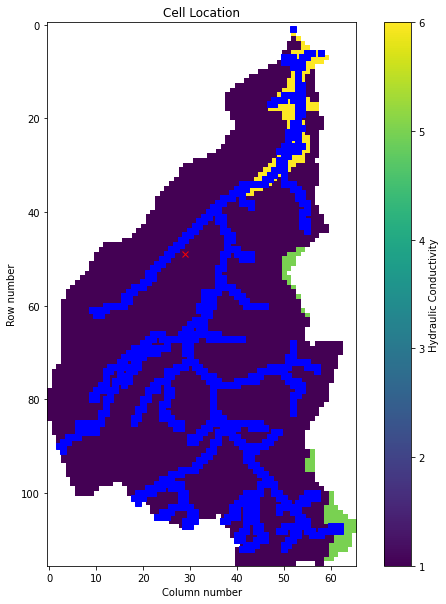

In [13]:
# Convert the row, column, and layer numbers to zero-based indexing
row = 92 - 1  # Corrected
col = 35 - 1  # Corrected
layer = 1 - 1

# Assume these are the coordinates of the failing cell
fail_row = 50 - 1
fail_col = 30 - 1
fail_layer = 1 - 1

# Check if the UPW package exists
if 'UPW' in sim.get_package_list():
    upw = sim.get_package('UPW')
    if upw is not None and hasattr(upw, 'hk'):
        # Get the cell information
        top = sim.dis.top.array[row, col]
        botm = sim.dis.botm.array[layer, row, col]
        thickness = top - botm  # Calculate the thickness
        hk = upw.hk.array[layer, row, col]
        ss = upw.ss.array[layer, row, col]
        sy = upw.sy.array[layer, row, col]

        # Print the cell information
        print(f"Thickness: {thickness}")
        print(f"HK: {hk}")
        print(f"SS: {ss}")
        print(f"SY: {sy}")

        # Get the ibound array from the BAS package
        ibound = sim.bas6.ibound.array

        # Create a masked array for the hydraulic conductivity where the ibound array is less than 1
        hk_masked = np.ma.masked_where(ibound[layer] < 1, upw.hk.array[layer])

        # Plot the location of the cell
        plt.figure(figsize=(10, 10))
        plt.imshow(hk_masked, cmap='viridis', interpolation='none')  # Plot the hydraulic conductivity
        plt.colorbar(label='Hydraulic Conductivity')
        plt.plot(col, row, 'ro')  # Plot the cell location

        # Check if the STR package exists and layer is zero
        if 'STR' in sim.get_package_list() and layer == 0:
            str = sim.get_package('STR')
            for data in str.stress_period_data[0]:
                layer, row, col, stage, conductance, bottom, top, width, slope, roughness, *rest = data
                plt.plot(col, row, 'bs')  # 'bs' means blue square

        # Plot the failing cell
        plt.plot(fail_col, fail_row, 'rx')  # 'rx' means red x

        plt.title('Cell Location')
        plt.xlabel('Column number')
        plt.ylabel('Row number')
        plt.show()
    else:
        print("UPW package does not have 'hk' attribute.")
else:
    print("UPW package does not exist.")

Try to use contast values

In [6]:
# Load the model
sim = flopy.modflow.Modflow.load('Gondebeek.nam')

# Change the version to 'mfnwt'
sim.version = 'mfnwt'

# Check if the PCG package exists before trying to remove it
if 'PCG' in sim.get_package_list():
    sim.remove_package('PCG')

# Check if the NWT package exists before trying to remove it
if 'NWT' in sim.get_package_list():
    sim.remove_package('NWT')

# Check if the LPF package exists before trying to remove it
if 'LPF' in sim.get_package_list():
    lpf = sim.get_package('LPF')
    if lpf is not None and hasattr(lpf, 'hk'):
        # Get the laytyp values from the LPF package
        laytyp = lpf.laytyp.array
        sim.remove_package('LPF')
    else:
        print("LPF package does not have 'hk' attribute. Cannot create UPW package.")
elif 'UPW' in sim.get_package_list():
    upw = sim.get_package('UPW')
    if upw is not None and hasattr(upw, 'hk'):
        # Get the laytyp values from the UPW package
        laytyp = upw.laytyp.array
        sim.remove_package('UPW')
    else:
        print("UPW package does not have 'hk' attribute. Cannot create UPW package.")
else:
    print("Neither LPF nor UPW package exists. Cannot create UPW package.")

# Create a new UPW package with constant parameters
hk = 10
vka = 1.0  # Assuming vertical hydraulic conductivity is the same as horizontal
sy = 0.05
ss = 0.009

upw = flopy.modflow.ModflowUpw(sim, hk=hk, vka=vka, sy=sy, ss=ss, laytyp=laytyp)

# Add the new UPW package to the model
sim.add_package(upw)

In [7]:
# Check if the NWT package exists before trying to remove it
if 'NWT' in sim.get_package_list():
    sim.remove_package('NWT')
# Create a new NWT solver with custom parameters
nwt = flopy.modflow.ModflowNwt(sim, 
                               headtol=0.001, 
                               fluxtol=600, 
                               maxiterout=3000, 
                               thickfact=1e-7, 
                               linmeth=2, 
                               iprnwt=1, 
                               ibotav=1, 
                               dbdtheta=0.8, 
                               dbdkappa=0.4, 
                               dbdgamma=0.5, 
                               momfact=0.5, 
                               backflag=1, 
                               maxbackiter=300, 
                               backtol=1.5, 
                               backreduce=0.6, 
                               iacl=1, 
                               norder=1, 
                               level=3, 
                               north=4, 
                               iredsys=1, 
                               rrctols=0.0, 
                               idroptol=1, 
                               epsrn=1e-3, 
                               hclosexmd=1e-3, 
                               mxiterxmd=250,
                               options='SPECIFIED')

# Add the new NWT package to the model
sim.add_package(nwt)

# Set the path to the MODFLOW-NWT executable
sim.exe_name = 'MODFLOW-NWT.exe'

# Write the entire model to disk
sim.write_input()

In [8]:
# Run the model
sim.run_model()

FloPy is using the following executable to run the model: MODFLOW-NWT.exe

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUNDWATER-FLOW MODEL
                             WITH NEWTON FORMULATION
                             Version 1.0.9 07/01/2014                        
                    BASED ON MODFLOW-2005 Version 1.11.0 08/08/2013                       

                    SWR1 Version 1.03.0 08/30/2013                       

 Using NAME file: Gondebeek.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2024/02/12 15:56:49

 Solving:  Stress period:     1    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:     1    Time step:     2    Groundwater-Flow Eqn.
 Solving:  Stress period:     1    Time step:     3    Groundwater-Flow Eqn.
 Solving:  Stress period:     1    Time step:     4    Groundwater-Flow Eqn.
 Solving:  Stress period:     1    Time step:     5    Groundwater-Flow Eqn.
 Solving:  S

(True, [])